In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

Basic statistics for returns in AAPL_Data.csv:
count    155.000000
mean       0.283871
std        0.452336
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Returns, dtype: float64 



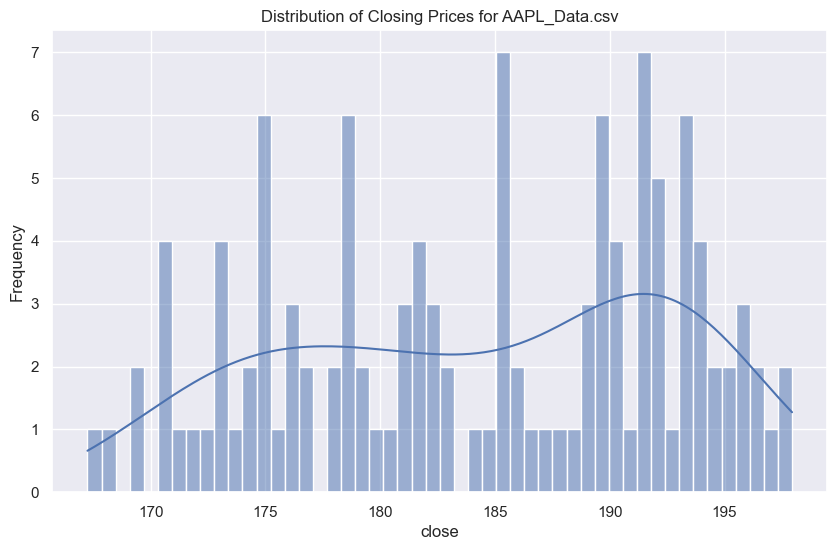

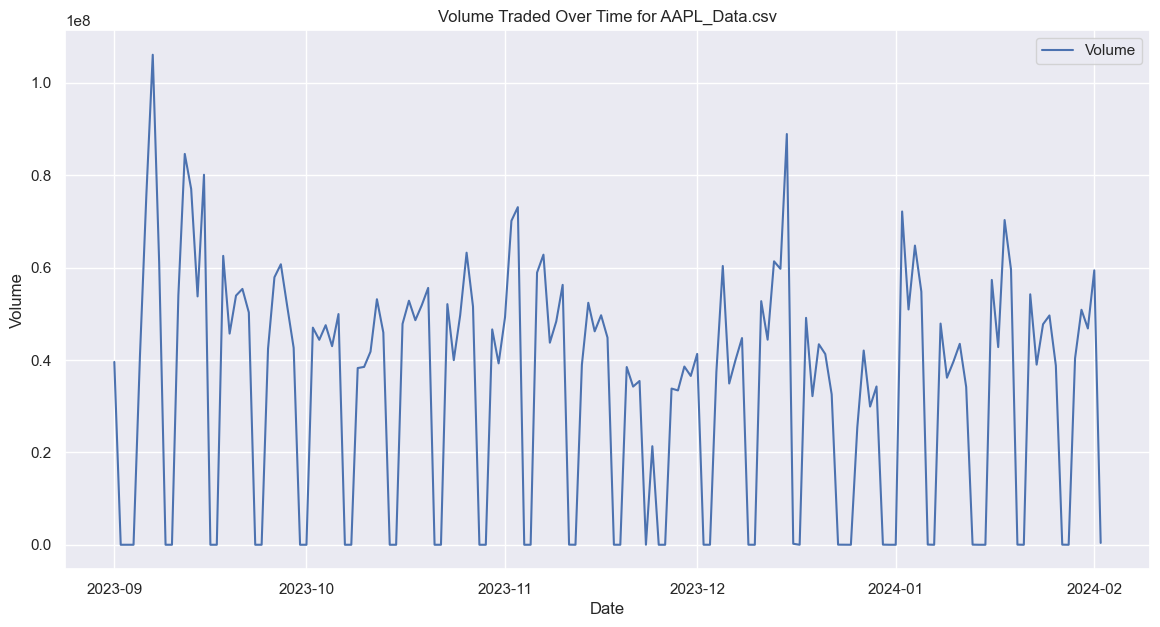

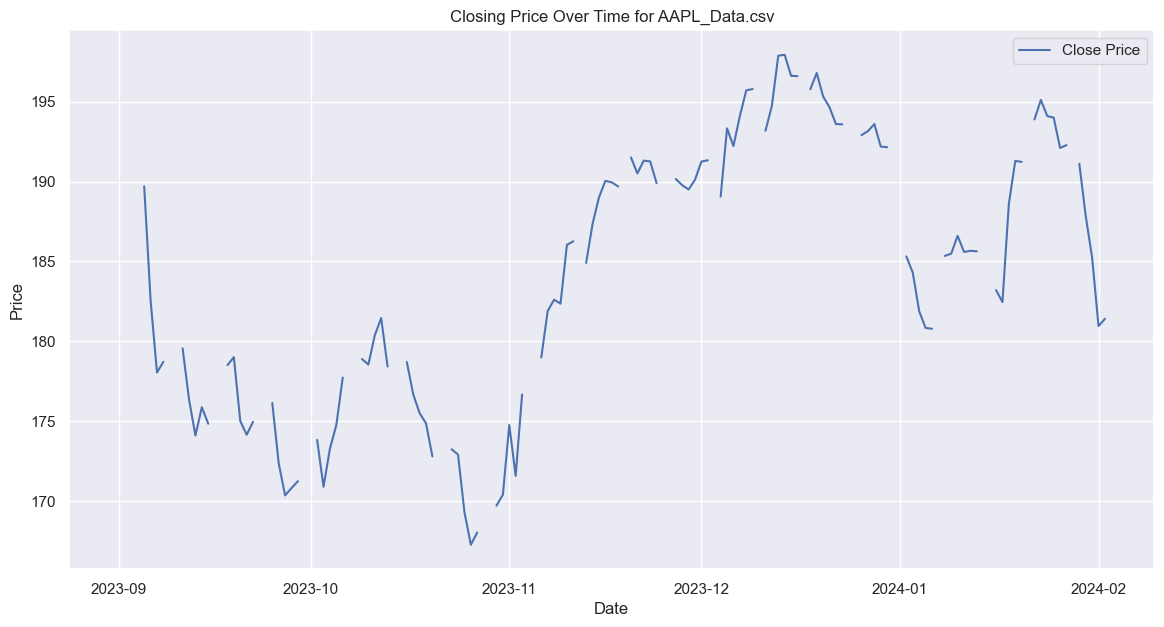

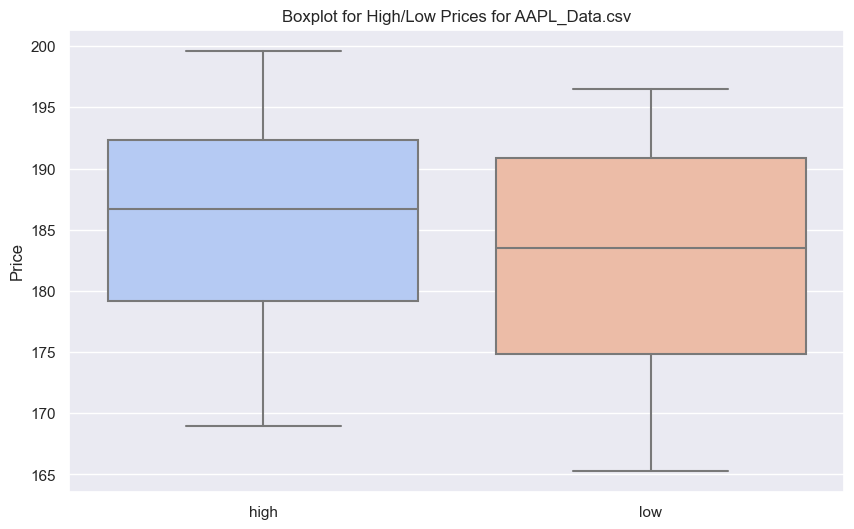

Basic statistics for returns in GOOGL_Data.csv:
count    155.000000
mean       0.329032
std        0.471385
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Returns, dtype: float64 



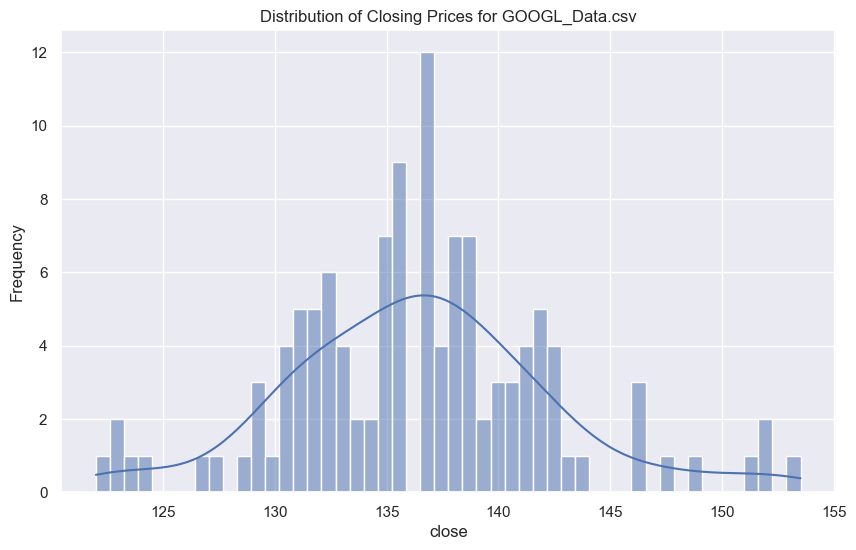

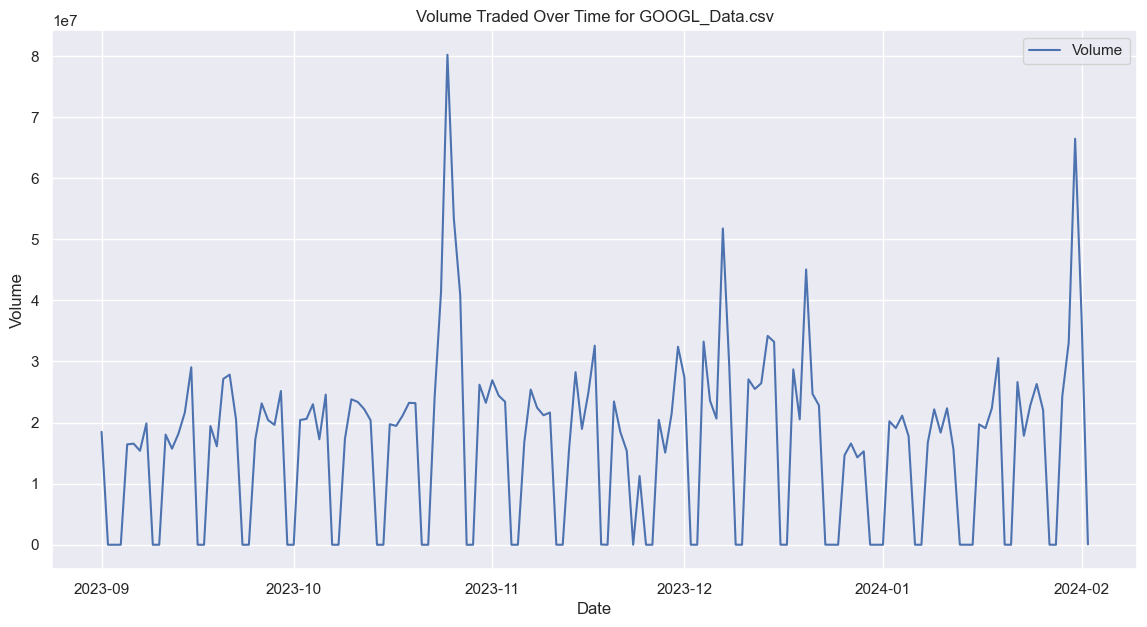

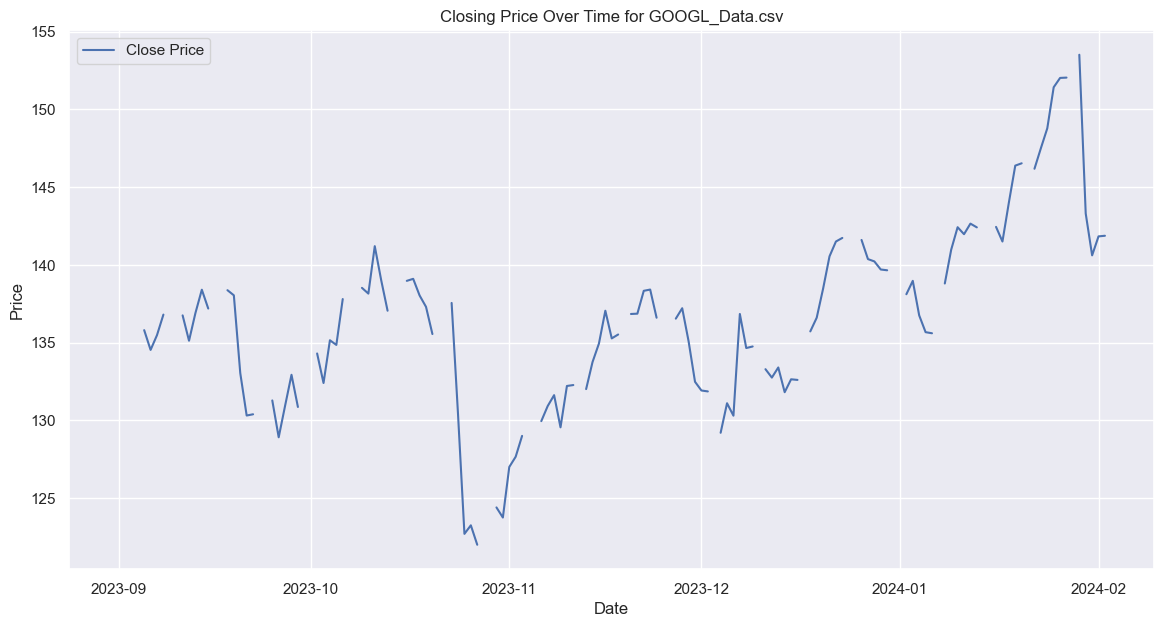

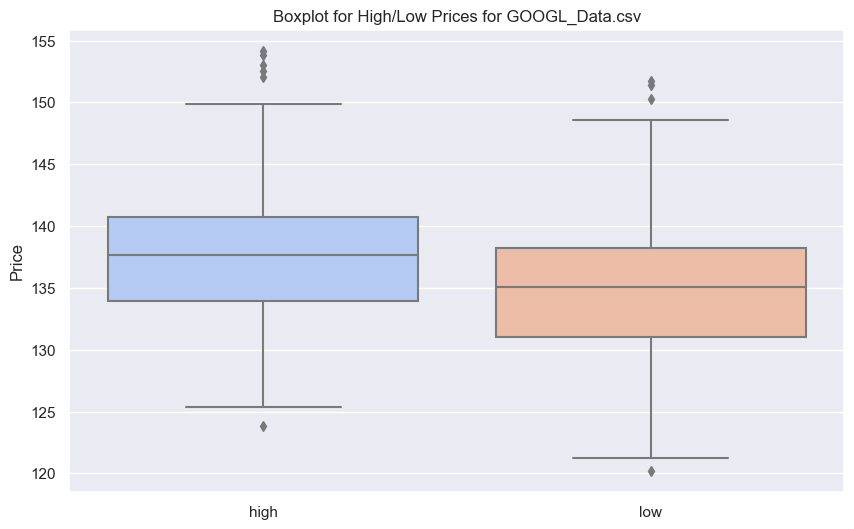

Basic statistics for returns in NVDA_Data.csv:
count    155.000000
mean       0.316129
std        0.466471
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Returns, dtype: float64 



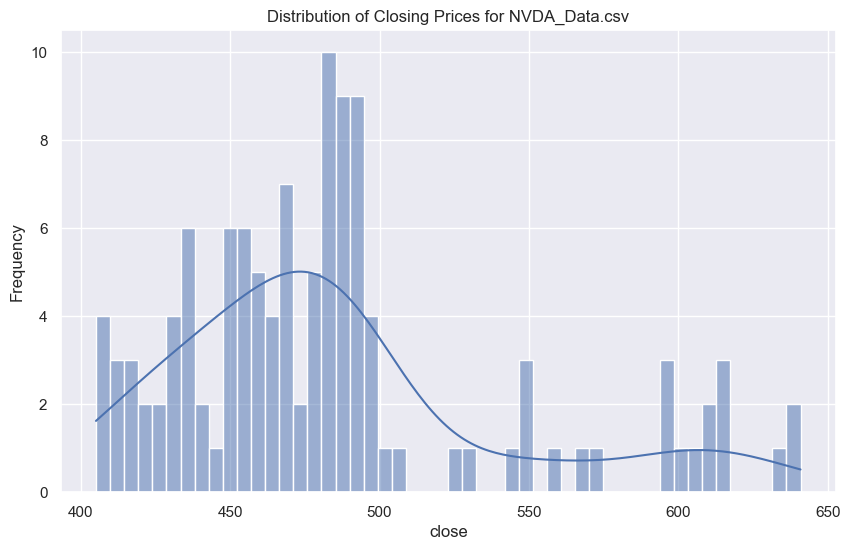

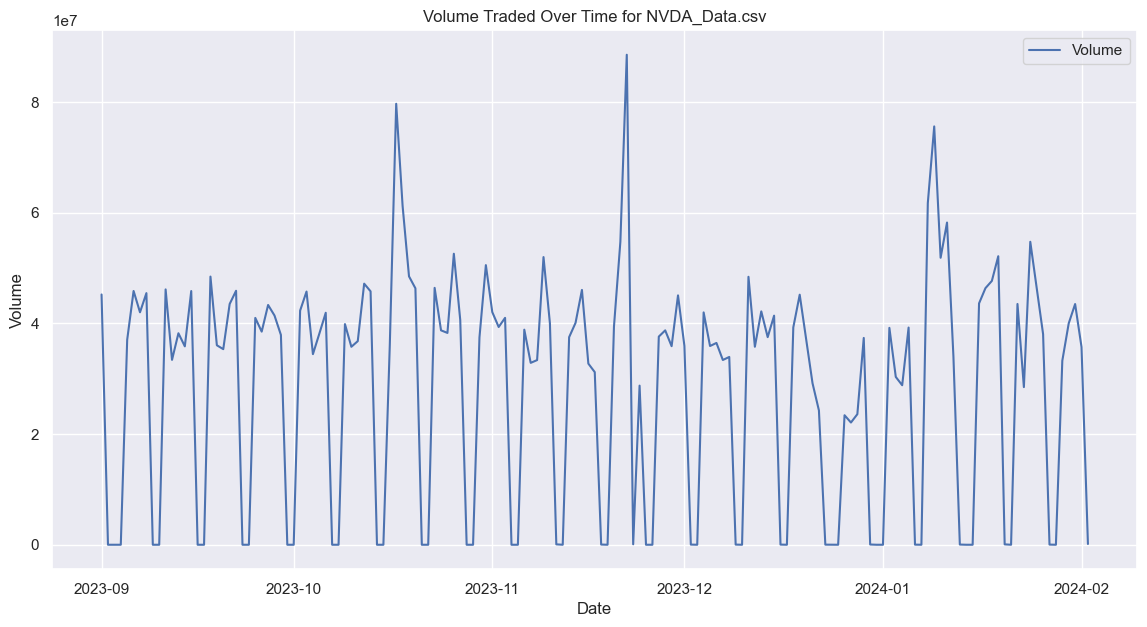

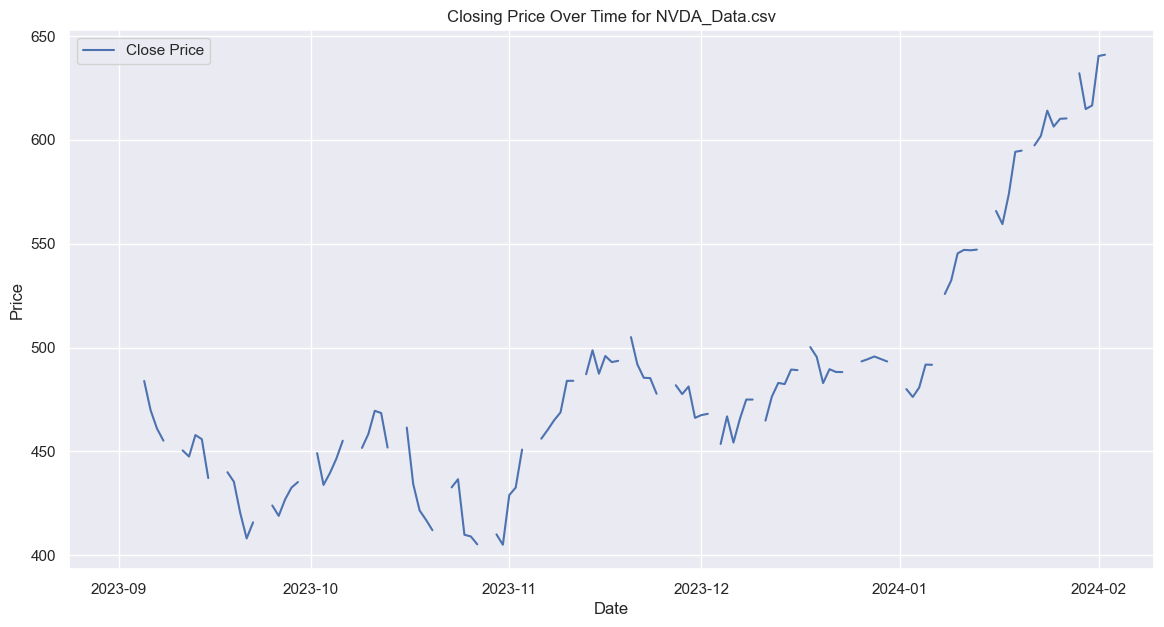

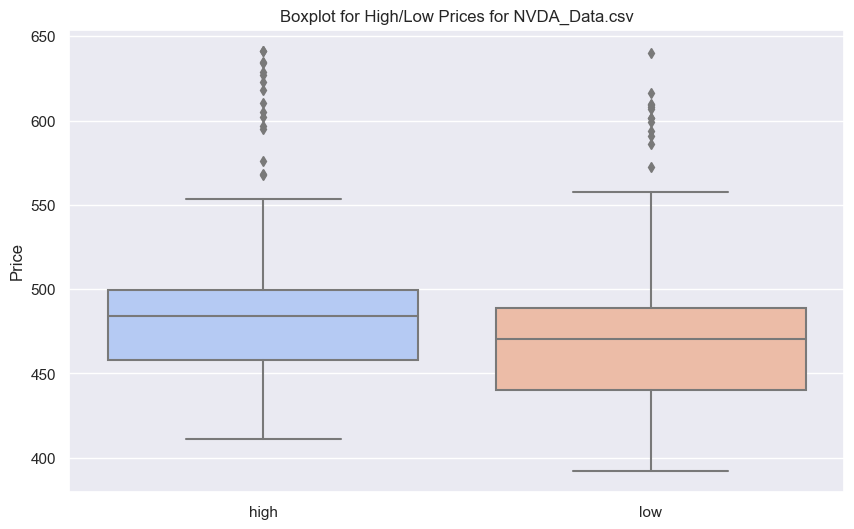

Basic statistics for returns in SPY_Data.csv:
count    155.000000
mean       0.329032
std        0.471385
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Returns, dtype: float64 



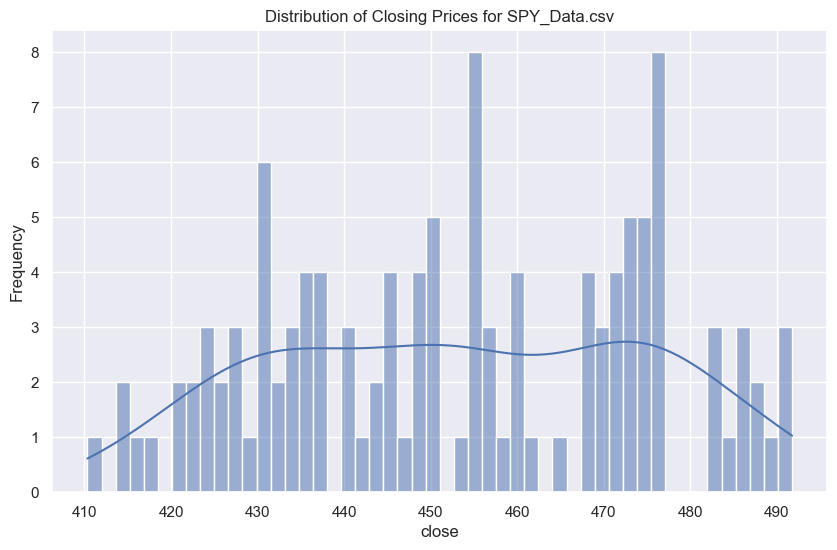

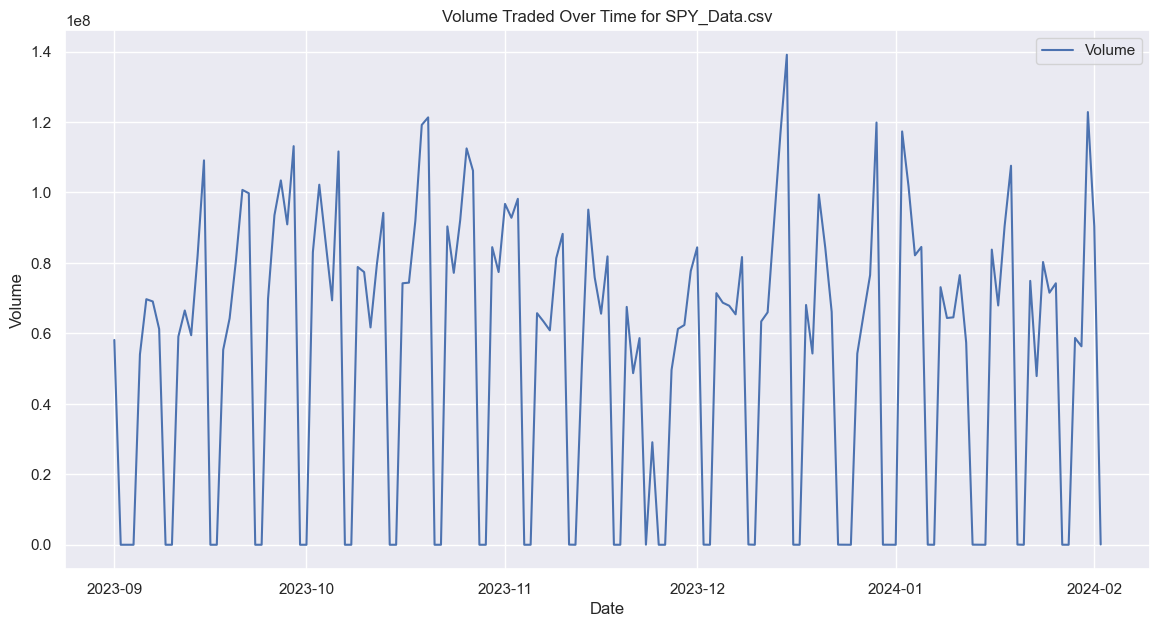

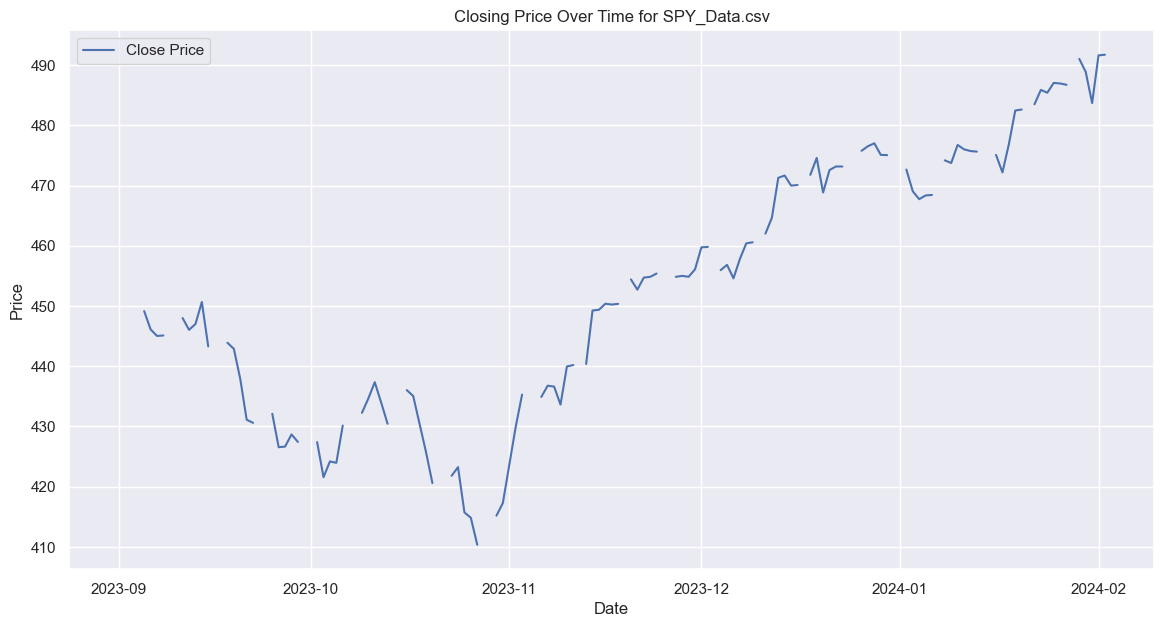

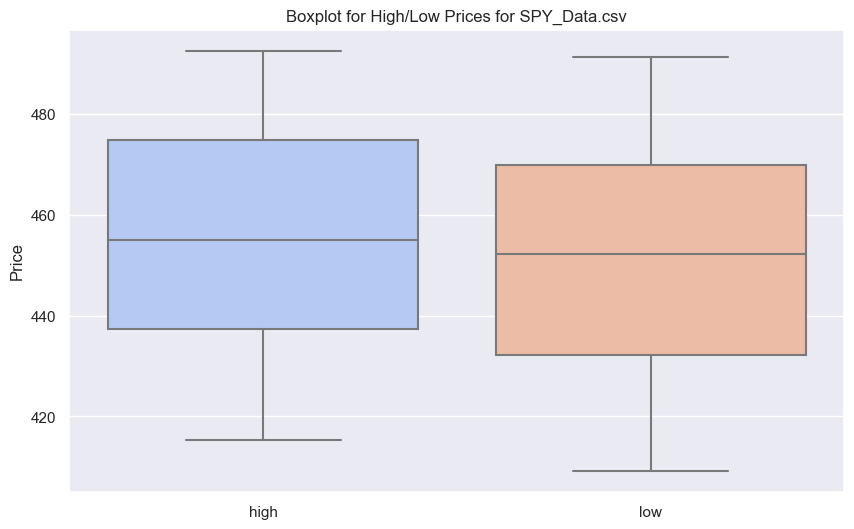

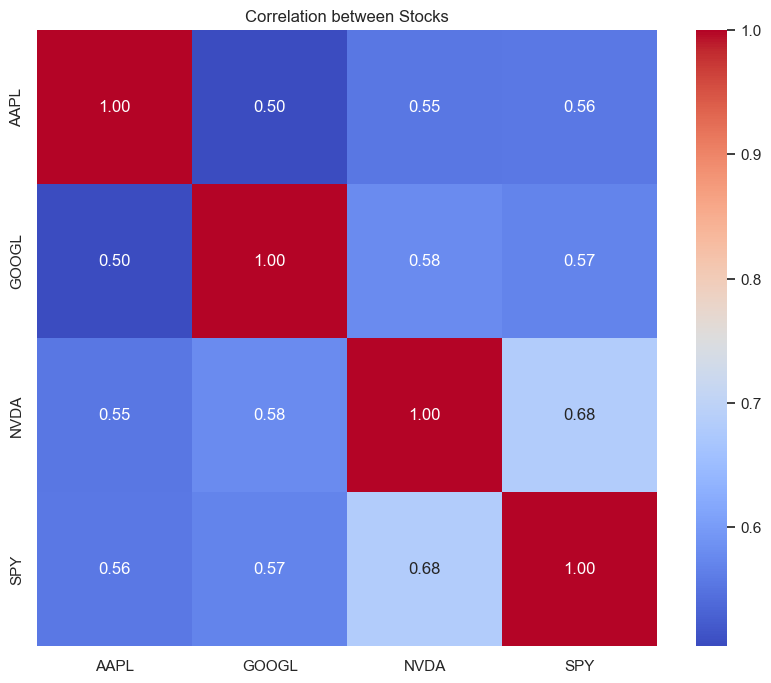

In [5]:
sns.set(style='darkgrid')

# Function to calculate returns comparing today's close with yesterday's
def calculate_returns(df):
    df['Prev_Close'] = df['close'].shift(1)  # Shift the 'close' column down
    df['Returns'] = np.where(df['close'] > df['Prev_Close'], 1, 0)
    df.drop(columns=['Prev_Close'], inplace=True)  # Remove the 'Prev_Close' column

# Function to plot histogram
def plot_histogram(df, column, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], bins=50, kde=True)
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Function to plot volume over time
def plot_volume(df, title):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['volume'], label='Volume')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.show()

# Function to plot closing price over time
def plot_close_price(df, title):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['close'], label='Close Price')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Function to analyze a single CSV file
def analyze_csv(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    try:
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')  # Assuming the timestamp is in seconds
    except Exception as e:
        print(f"Error converting timestamp in file {file_path}: {e}")
        return None

    df.set_index('timestamp', inplace=True)
    
    # Resample to daily data assuming 'timestamp' is more granular than 1D
    daily_df = df.resample('D').agg({'open': 'first', 'high': 'max', 'low': 'min', 
                                     'close': 'last', 'volume': 'sum', 'vwap': 'mean', 
                                     'transactions': 'sum', 'otc': 'sum'})
    
    # Calculate returns
    calculate_returns(daily_df)
    
    # Basic statistics for returns
    print(f"Basic statistics for returns in {file_path}:")
    print(daily_df['Returns'].describe(), '\n')
    
    # Plotting
    plot_histogram(daily_df, 'close', f"Distribution of Closing Prices for {file_path}")
    plot_volume(daily_df, f"Volume Traded Over Time for {file_path}")
    plot_close_price(daily_df, f"Closing Price Over Time for {file_path}")
    
    # Boxplot for high/low price (volatility)
    plot_boxplot(daily_df, f"Boxplot for High/Low Prices for {file_path}")
    
    return daily_df  # Return the daily DataFrame for further analysis

# Function to plot box plots for volatility
def plot_boxplot(df, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df[['high', 'low']], palette="coolwarm")
    plt.title(title)
    plt.ylabel('Price')
    plt.show()

# Initialize a dictionary to store daily data for each stock
daily_data = {}

# List of file paths
file_paths = ['AAPL_Data.csv', 'GOOGL_Data.csv', 'NVDA_Data.csv', 'SPY_Data.csv']

# Analyze each CSV file
for file_path in file_paths:
    stock_name = file_path.split('_')[0]  # Extract stock name from file path
    daily_data[stock_name] = analyze_csv(file_path)

# Calculate and plot correlations between the stocks
close_prices = pd.DataFrame()
for stock_name, data in daily_data.items():
    close_prices[stock_name] = data['close']

plt.figure(figsize=(10, 8))
sns.heatmap(close_prices.pct_change().corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation between Stocks')
plt.show()